# Notebook to explore the fitness data



In [18]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from pathlib import Path
from os import path

home = Path(path.abspath('..'))
data = home / 'book_data'



## Read the Data

The data is kept in an excel file called *Fitness.csv*, in a sheet named "Data."

Need to fill the Nan/Blank columns with 0.

In [19]:
values = {"Str_Trng":0, "Func_Trng":0, "Yoga":0, "Run":0, "Walk":0, "Hike":0, "Bike":0,"Other": 0,"Activity":0}
dtypes = {"Func_Trng":np.float64}
raw_df = pd.read_excel(data / 'Fitness.xlsx' ,sheet_name='Data', dtype=dtypes).fillna(value=values)


In [20]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123 entries, 0 to 122
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       123 non-null    datetime64[ns]
 1   Weight     104 non-null    float64       
 2   BF         87 non-null     float64       
 3   Activity   123 non-null    int64         
 4   Str_Trng   123 non-null    float64       
 5   Func_Trng  123 non-null    float64       
 6   Yoga       123 non-null    float64       
 7   Run        123 non-null    float64       
 8   Walk       123 non-null    float64       
 9   Hike       123 non-null    float64       
 10  Bike       123 non-null    float64       
 11  Other      123 non-null    float64       
 12  Steps      89 non-null     float64       
 13  Miles      74 non-null     float64       
 14  Flights    74 non-null     float64       
dtypes: datetime64[ns](1), float64(13), int64(1)
memory usage: 14.5 KB


## Calculations

The data is simply as recorded from the data sources. There are a few calculations to make.

The first is to calculate the active calories from the named activities.These activities record data when in the fitness mode.  This Series contains the "residual" value of activity (kCal) not associated with a "walking" type activity.


In [21]:
raw_df['Step_Act'] = raw_df.apply(lambda row: (row['Activity']-(row['Str_Trng']+
                                                row['Func_Trng']+
                                                row['Yoga']+
#                                                row['Run']+
#                                                row['Walk']+
#                                                row['Hike']+
                                                row['Bike']+
                                                row['Other'])
                                                ), axis=1)

steps_df=raw_df.loc[:,['Step_Act','Steps','Flights']].dropna()
#steps_df

## Investigate Steps

Given that we now have the "excess" actvity associateded with steps, lets see if there is strong corelation using linear regression.

In [22]:
# Helper Function MSE  NOT NEEDED SEE Scikit.metrics.mean_squared_error
def MSE(act : np.ndarray, pred : np.ndarray) -> np.float64 :
    n = len(act)
    sum = 0
    for i in range(0,n):
        diff_squared = (act[i] - pred[i])**2
    return diff_squared/n

def predict_y_2P(model : LinearRegression, x_matrix : np.ndarray) -> np.ndarray:
    x1_coeff = model.coef_[0]
    x2_coeff = model.coef_[1]
    intercept = model.intercept_
    
    return x_matrix.iloc[:,0]*x1_coeff + x_matrix.iloc[:,1]*x2_coeff + intercept


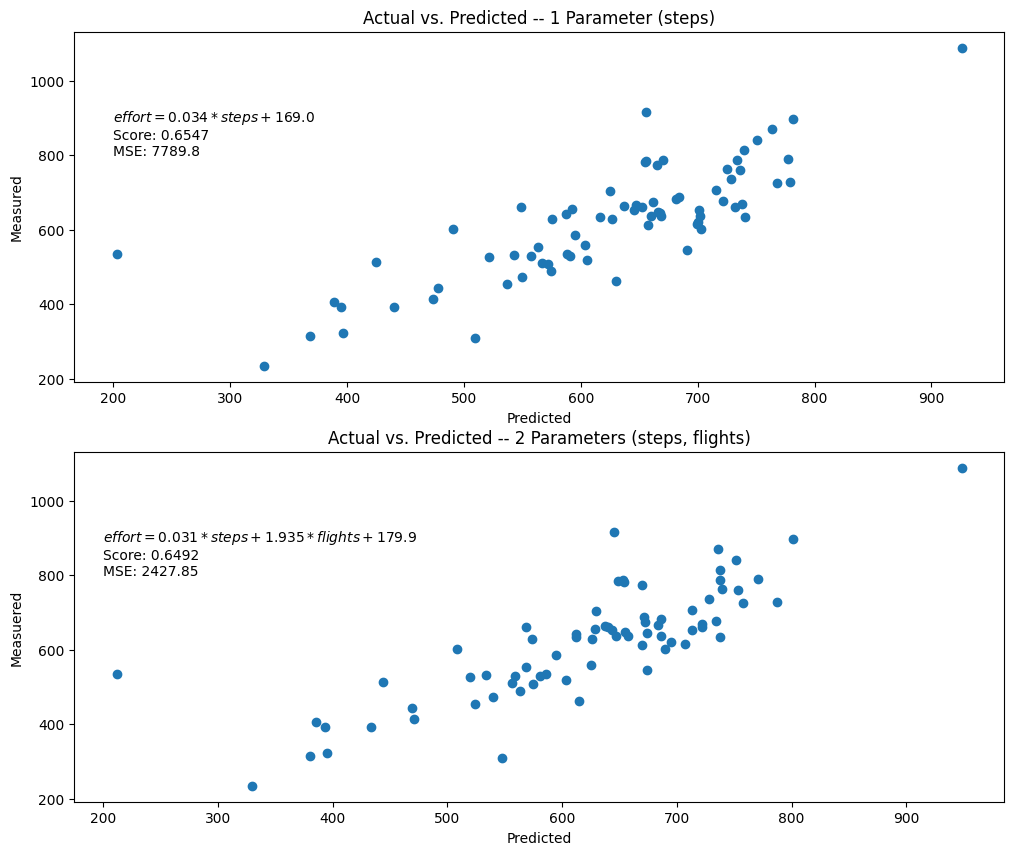

In [23]:
X = steps_df['Steps'].to_numpy().reshape(-1,1)
y1 = steps_df['Step_Act'].to_numpy()

# Create a linear regression model
model1 = LinearRegression()

# Fit the model to the data
model1.fit(X, y1)

# Make predictions
y1_pred = model1.predict(X)

# Create the Plots
fig, axes = plt.subplots(2,1, figsize=(12.0, 10.0))


# Plot the data and the regression line for 1 paramter
axes[0].set_title('Actual vs. Predicted -- 1 Parameter (steps)')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Measured')
#axes[0].text(450,750, )
axes[0].scatter(y1_pred, y1)
axes[0].text(200,800, f'$effort = {np.round(model1.coef_[0],3)} * steps + {np.round(model1.intercept_,1)}$\nScore: {np.round(model1.score(X,y1), 4)}\nMSE: {np.round(mean_squared_error(y1, y1_pred),1)}')


# Prepare data for two parameter analysis
X2 = steps_df[['Steps', 'Flights']]  # Independent variables
y2 = steps_df['Step_Act']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X2, y2, test_size=0.2, random_state=42)# Dependent variable

# Create and fit the model
model2 = LinearRegression()
model2.fit(X_train, y_train)

# Make predictions
y_pred = model2.predict(X_test)

axes[1].set_title('Actual vs. Predicted -- 2 Parameters (steps, flights)')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Measuered')
axes[1].scatter(predict_y_2P(model2, X2), y2)
axes[1].text(200,800, f'$effort = {np.round(model2.coef_[0],3)} * steps + {np.round(model2.coef_[1],3)} * flights + {np.round(model2.intercept_,1)}$\nScore: {np.round(model2.score(X_train,y_train), 4)}\nMSE: {np.round(mean_squared_error(y_test, y_pred),2)}')


plt.show()


# A little side exploration

This is data which is *NOT* recorded by the fitness app--I take manual readings

In [24]:
#dtypes = {"Func_Trng":np.float64}
manual_df = pd.read_excel(data / 'Fitness.xlsx' ,sheet_name='Walk')
#manual_df.info()


X_train = manual_df[['steps','flights']]
                    
y_train = manual_df[['act']]

model3 = LinearRegression()
model3.fit(X_train, y_train)

print(f'Coefficients: {model3.coef_}\nIntercept: {model3.intercept_}')
y_pred = model3.predict([[2327,4],
                    ])
print(y_pred)



Coefficients: [[0.02733668 2.02592112]]
Intercept: [54.98619291]
[[126.70233531]]


/Users/edmundlskoviak/Documents/repos/pyspark-playground/vpython3.12/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


## Lean Body Mass

$ LBM = Weight * (1 - \frac{BF}{100}) $

In [25]:
LBM_df = raw_df.loc[:,['Date','Weight','BF']].dropna()
LBM_df['LBM'] = LBM_df['Weight']*(1 - (LBM_df['BF']/100))

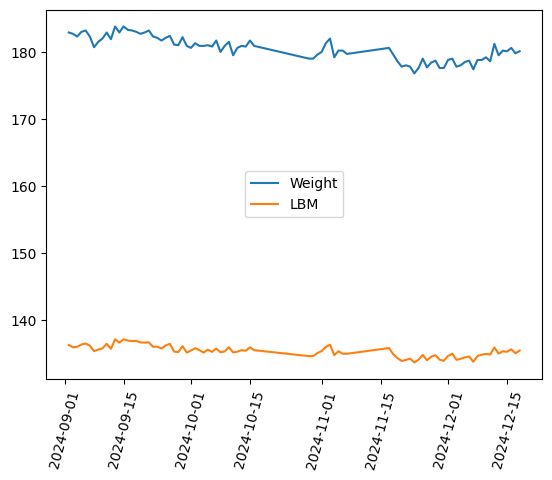

In [ ]:
#LBM_df
fig, ax = plt.subplots()
ax.plot(LBM_df['Date'], LBM_df.loc[:,['Weight','LBM']], label=['Weight','LBM'])
ax.tick_params(axis='x', labelrotation=75)

plt.legend(loc='center') 
plt.show()

## Explore the Spread of reported Activity

IQR:
0.25     937.5
0.50    1039.0
0.75    1133.0
Name: Activity, dtype: float64


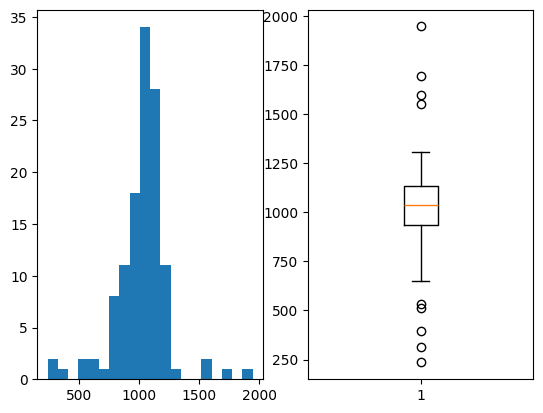

In [ ]:
data = raw_df.loc[:,'Activity'].dropna()
print(f'IQR:\n{data.quantile([.25,.50,.75])}')
n_bins = 20

fig, axs = plt.subplots(1, 2,)

# We can set the number of bins with the *bins* keyword argument.
axs[0].hist(data, bins=n_bins)
axs[1].boxplot(data)

plt.show()